In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.feature_extraction.text import CountVectorizer
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, NuSVC, LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
import seaborn as sns


df = pd.read_csv('tweets.csv', encoding= 'utf-8')

In [51]:
df1 = df[['handle', 'text', 'is_retweet']]

df2 = df1.loc[df1['is_retweet'] == False]

df2 = df2.copy().reset_index(drop=True)

df2['is_trump'] = df2['handle'].apply(lambda x: 1 if x== 'realDonaldTrump' else 0) 

PREPROCESSING

In [52]:
def remove_punctuation(text):
    lower = text.lower()
    exclude = set(string.punctuation)
    return "".join(ch for ch in lower if ch not in exclude)

df2['processed_text'] = df2['text'].apply(remove_punctuation)

def remove_stopwords(x):
    lower = x.lower()
    split = lower.split()
    final = ''
    for i in split:
        if i not in stopwords.words('english'):
            final += (i + " ")
    return final

df2['processed_text1'] = df2['processed_text'].apply(remove_stopwords)

stemmer = PorterStemmer()

def split_and_stem(string):
    string = string.split(' ')
    temp = ""
    for i in string:
        temp += (stemmer.stem(i) + " ")
    return temp

df2['processed_text2'] = df2['processed_text1'].apply(split_and_stem)



In [53]:
x = df2['processed_text2']
y = df2['is_trump']

x_train, x_test, y_train, y_test = train_test_split(x, y)

In [54]:
tfidf = TfidfVectorizer()

In [55]:
df_train  = pd.DataFrame(tfidf.fit_transform(x_train).todense(),
             columns=tfidf.get_feature_names())

In [56]:
df_test = pd.DataFrame(tfidf.transform(x_test).todense(),
             columns=tfidf.get_feature_names())

In [57]:
rfc = RandomForestClassifier()

In [58]:
rfc.fit(df_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [59]:
def run_model(x_train, y_train, x_test, y_test, rfc):
    rfc.fit(x_train, y_train)
    print "Base model score: " + str(np.mean(y_test))[:6]
    print "Training set score: ", str(rfc.score(x_train, y_train))[:6]
    print "Test set score: ", str(rfc.score(x_test, y_test))[:6]
    predictions = rfc.predict(x_test)
    print "\nConfusion Matrix:\n", pd.DataFrame(confusion_matrix(y_test, predictions), 
                                              columns=['predicted_0', 'predicted_1'], index=['is_0', 'is_1'])
    print "\nClassification Report:\n",classification_report(y_test, predictions)

In [60]:
run_model(df_train, y_train, df_test, y_test, rfc)

Base model score: 0.5478
Training set score:  0.9944
Test set score:  0.8714

Confusion Matrix:
      predicted_0  predicted_1
is_0          598           49
is_1          135          649

Classification Report:
             precision    recall  f1-score   support

          0       0.82      0.92      0.87       647
          1       0.93      0.83      0.88       784

avg / total       0.88      0.87      0.87      1431



In [61]:
rfc_y_score = rfc.predict_proba(df_test)[:,1]

In [62]:
print roc_auc_score(y_test, rfc_y_score)

0.947176726177


In [63]:
rfc_FPR = dict()
rfc_TPR = dict()
rfc_ROC_AUC = dict()

In [64]:
roc_curve(y_test, rfc_y_score)

(array([ 0.        ,  0.00309119,  0.00927357,  0.0309119 ,  0.04945904,
         0.07573416,  0.12982998,  0.23338485,  0.37712519,  0.57341577,
         0.77897991,  1.        ]),
 array([ 0.        ,  0.34183673,  0.50765306,  0.63265306,  0.74362245,
         0.82780612,  0.89285714,  0.94515306,  0.98086735,  0.98852041,
         0.99744898,  1.        ]),
 array([ 2. ,  1. ,  0.9,  0.8,  0.7,  0.6,  0.5,  0.4,  0.3,  0.2,  0.1,
         0. ]))

In [65]:
rfc_FPR[1], rfc_TPR[1], _ = roc_curve(y_test, rfc_y_score)
rfc_ROC_AUC[1] = auc(rfc_FPR[1], rfc_TPR[1])

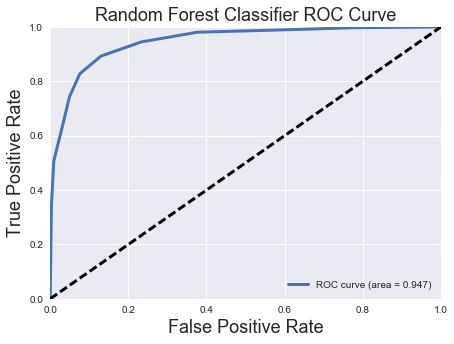

In [66]:
plt.figure(figsize=[7,5])
plt.plot(rfc_FPR[1], rfc_TPR[1], label='ROC curve (area = %0.3f)' % rfc_ROC_AUC[1], linewidth=3)
plt.plot([0, 1], [0, 1], 'k--', linewidth=3)
plt.xlim([0.0, 1])
plt.ylim([0.0, 1])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Random Forest Classifier ROC Curve', fontsize=18)
plt.legend(loc="lower right")
plt.show()

In [67]:
linearsvc = LinearSVC()

In [68]:
run_model(df_train, y_train, df_test, y_test, linearsvc)

Base model score: 0.5478
Training set score:  0.9995
Test set score:  0.9245

Confusion Matrix:
      predicted_0  predicted_1
is_0          594           53
is_1           55          729

Classification Report:
             precision    recall  f1-score   support

          0       0.92      0.92      0.92       647
          1       0.93      0.93      0.93       784

avg / total       0.92      0.92      0.92      1431

